In [1]:
# %matplotlib notebook
# %matplotlib inline 
%load_ext autoreload
%autoreload 2

# import sys
# sys.path.append("Codes/")
# import TMPD_understanding_tasks.py
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as ss
import pm4py
from pm4py.objects.dfg.obj import DFG
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
pd.set_option("display.max_rows", 100)
pd.set_option("display.expand_frame_repr", True)
pd.set_option('display.width', 1000)

In [2]:
# # Read the content of each sheet
# reference_window_df = pd.read_excel("Input/Test/GPT_ConceptDrift_Samples.xlsx", sheet_name='Reference Window')
# detection_window_df = pd.read_excel("Input/Test/GPT_ConceptDrift_Samples.xlsx", sheet_name='Detection Window')

# # Filter rows where any of the frequency columns are greater than 0
# reference_window_df = reference_window_df[reference_window_df["Frequency"] > 0].dropna(how='all')
# detection_window_df = detection_window_df[detection_window_df["Frequency"] > 0].dropna(how='all')
# display(reference_window_df)

In [66]:
import glob
import sys
sys.path.append("Codes/")
import TMPD_utils
import TMPD_class

# Mapping all event_logs paths
logs_path = glob.glob("Input/Synthetic/Business Process Drift (Maaradji - Fast)/logs/*/*k.*")

# Removing the logs with 2500 and 5000 events (based on Maaradji paper)
logs_path = [x for x in logs_path if "7.5" in x or "10" in x]

# Loading first event log
log_path = logs_path[2]
print(log_path.split("\\")[-1].split(".")[0])
event_log = TMPD_utils.parse_mxml(log_path)

# This is a specifc step for this event log that separates in different rows the start and end of an activity. As we will only use one timestamp, we are filtering only the row representing the end of an activity.  
event_log = event_log[event_log.EventType == "complete"]

# Save original event index
event_log = event_log.reset_index(names='original_index') 

# Create an id based on the order of the event in the raw event log
event_log["Event_order_id"] = event_log.index

# This is a specifc step for this event log, because it have duplicated case ids. So we create a new case id.
event_log["Trace_order"] = TMPD_utils.cumulative_counting(event_log["CaseId"])

# Add a Start and End actiivities case it doesn't have
event_log = TMPD_utils.add_start_end_activities(event_log=event_log, case_id_col="Trace_order", activity_col="Activity", timestamp_col="Timestamp")

def TMPD_creation(event_log):

    # Iniatializing the TMPD_class
    TMPD_instance = TMPD_class.TMPD(scenario='offline')

    # Setting the transition log
    TMPD_instance.set_transition_log(event_log, case_id='Trace_order', activity_key='Activity', timestamp_key='Timestamp', timestamp_format=None, other_columns_keys=[])

    # Executing the transition log
    TMPD_instance.run_transition_log()

    # Setting the window strategy parameters
    TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 4000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 200, continuous = True)

    # Executing the window strategy indexation
    TMPD_instance.run_windowing_strategy()

    # Setting the Transition Matrix (TM) process representation
    TMPD_instance.set_process_representation(threshold_anomaly=0
                                        , control_flow_features={'frequency', 'probability'}
                                        , time_features={} #{'avg_time':'timestamp', 'time_std':'timestamp'}
                                        , resource_features={}
                                        , data_features={})

    # Executing the process_representation using all dataset just for an example
    TMPD_instance.run_process_representation(TMPD_instance.transition_log)

    # Showing the process representation created
    return TMPD_instance.get_process_representation()

ref = TMPD_creation(event_log[0:4000])
det = TMPD_creation(event_log[14000:18000])

# Filter rows where any of the frequency columns are greater than 0
reference_window_df = ref[ref["frequency"] > 0].dropna(how='all')
detection_window_df = det[det["frequency"] > 0].dropna(how='all')

reference_window_df = reference_window_df.reset_index()
detection_window_df = detection_window_df.reset_index()

display(reference_window_df)
display(detection_window_df)


cd10k


,activity_from,activity_to,probability,frequency
0,Appraise_property,Assess_eligibility,0.291925,94
1,Appraise_property,Assess_loan_risk,0.251553,81
2,Appraise_property,Check_credit_history,0.456522,147
3,Approve_application,Loan__application_approved,1.000000,80
4,Assess_eligibility,Prepare_acceptance_pack,0.512422,165
5,Assess_eligibility,Reject_application,0.487578,157
6,Assess_loan_risk,Appraise_property,0.291925,94
7,Assess_loan_risk,Assess_eligibility,0.708075,228
8,Cancel_application,Loan__application_canceled,1.000000,85
9,Check__application__form_completeness,Appraise_property,0.406077,147


,activity_from,activity_to,probability,frequency
0,Appraise_property,Assess_loan_risk,0.457576,151
1,Appraise_property,Check_credit_history,0.542424,179
2,Approve_application,Loan__application_approved,1.000000,78
3,Assess_eligibility,Prepare_acceptance_pack,0.454545,150
4,Assess_eligibility,Reject_application,0.545455,180
5,Assess_loan_risk,Assess_eligibility,1.000000,330
6,Cancel_application,Loan__application_canceled,1.000000,72
7,Check__application__form_completeness,Appraise_property,0.493113,179
8,Check__application__form_completeness,Check_credit_history,0.415978,151
9,Check__application__form_completeness,Return_application_back_to_applicant,0.090909,33


In [67]:
# import glob
# import sys
# sys.path.append("Codes/")
# import TMPD_utils
# import TMPD_class

# # Mapping all event_logs paths
# logs_path = glob.glob("Input/Synthetic/CPN_Logs (Ostovar - Robust)/FragmentChange/*/*/*/*/*.mxml*")

# # Loading first event log
# log_path = logs_path[0]
# print(log_path.split("\\")[-5] + "/" + log_path.split("\\")[-1].split(".")[0])
# event_log = TMPD_utils.parse_mxml(log_path, gzip=True)

# # This is a specifc step for this event log that remove an activity that shows where the drift happens
# event_log = event_log[event_log['WorkflowModelElement'] != 'DRIFT_PO']

# # Save original event index
# event_log = event_log.reset_index(names='original_index') 

# # Create an id based on the order of the event in the raw event log
# event_log["Event_order_id"] = event_log.index

# # Add a Start and End actiivities case don't have
# event_log = TMPD_utils.add_start_end_activities(event_log=event_log, case_id_col="CaseId", activity_col="Activity", timestamp_col="timestamp")

# def TMPD_creation(event_log):

#     # Iniatializing the TMPD_class
#     TMPD_instance = TMPD_class.TMPD(scenario='offline')

#     # Setting the transition log
#     TMPD_instance.set_transition_log(event_log, case_id='CaseId', activity_key='Activity', timestamp_key='timestamp', timestamp_format=None, other_columns_keys=[])

#     # Executing the transition log
#     TMPD_instance.run_transition_log()

#     # Setting the window strategy parameters
#     TMPD_instance.set_windowing_strategy(window_size_mode = 'Fixed', window_size = 8000, window_ref_mode = 'Fixed', overlap = True, sliding_step = 2000, continuous = True)

#     # Executing the window strategy indexation
#     TMPD_instance.run_windowing_strategy()

#     # Setting the Transition Matrix (TM) process representation
#     TMPD_instance.set_process_representation(threshold_anomaly=0
#                                         , control_flow_features={'frequency', 'probability'}
#                                         , time_features={} #'avg_time':'timestamp', 'time_std':'timestamp'
#                                         , resource_features={}
#                                         , data_features={})

#     # Executing the process_representation using all dataset just for an example
#     TMPD_instance.run_process_representation(TMPD_instance.transition_log)

#     # Showing the process representation created
#     return TMPD_instance.get_process_representation()

# ref = TMPD_creation(event_log[0:8000])
# det = TMPD_creation(event_log[30000:38000])

# # Filter rows where any of the frequency columns are greater than 0
# reference_window_df = ref[ref["frequency"] > 0].dropna(how='all')
# detection_window_df = det[det["frequency"] > 0].dropna(how='all')

# reference_window_df = reference_window_df.reset_index()
# detection_window_df = detection_window_df.reset_index()

# display(reference_window_df)
# display(detection_window_df)

In [68]:
# Helper function to identify the type of variable
def identify_statistical_test(series):
    """
    Identify the type of variable based on its values.
    - 'proportion' if values are between 0 and 1.
    - 'continuous' otherwise.
    """
    if np.all((series >= 0) & (series <= 1)):
        return 'proportion_test'
    return 'count_test'


# Calculate Cohen's h effect size for proportions.
def cohen_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))


# Calculate Cramers V statistic for categorical-categorical association
def cramers_corrected_stat(data, ref_column, det_column, ref_value, det_value):
    # Calculate total counts for ref and det
    total_ref = data[ref_column].sum() - ref_value
    total_det = data[det_column].sum() - det_value

    # Constructing the contingency table
    contingency_table = np.array([[ref_value, total_ref], [det_value, total_det]])

    # Perform Chi-squared test with correction
    chi2 = ss.chi2_contingency(contingency_table, correction=True, lambda_='log-likelihood')[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


# Function to perform count test (Chi-squared or Fisher's exact test)
def perform_count_test(merged_windows, row, variable_ref, variable_det):
    freq_reference = row[variable_ref]
    freq_detection = row[variable_det]
    total_freq_reference = merged_windows[variable_ref].sum() - freq_reference
    total_freq_detection = merged_windows[variable_det].sum() - freq_detection
    contingency_table = [[freq_reference, total_freq_reference], [freq_detection, total_freq_detection]]

    if 0 in contingency_table or min(min(contingency_table)) < 5:
        _, p_value = fisher_exact(contingency_table)
    else:
        _, p_value, _, _ = chi2_contingency(contingency_table)
    return p_value


# Adjusted function with pseudo-count (also known as Laplace smoothing) for handling zero frequencies
def perform_proportions_test(merged_windows, row, transition, variable_ref, variable_det, pseudo_count=0.5):
    prob_reference = row[variable_ref]
    prob_detection = row[variable_det]

    # Check for equal values, return non-significant p-value
    if prob_reference == prob_detection:
        return 1

    total_count_reference = merged_windows.loc[merged_windows['activity_from'] == transition[0], 'frequency_ref'].sum()
    total_count_detection = merged_windows.loc[merged_windows['activity_from'] == transition[0], 'frequency_det'].sum()

    # Add pseudo-count
    success_reference = int(round(prob_reference * (total_count_reference + pseudo_count)))
    success_detection = int(round(prob_detection * (total_count_detection + pseudo_count)))

    # Calculate standard deviation
    std = np.sqrt((prob_reference * (1 - prob_reference) / (total_count_reference + pseudo_count)) +
                  (prob_detection * (1 - prob_detection) / (total_count_detection + pseudo_count)))

    # Avoid divide by zero
    if std == 0:
        return 1

    # Perform the test
    stat, p_value = proportions_ztest([success_reference, success_detection], 
                                      [total_count_reference + pseudo_count, total_count_detection + pseudo_count])
    return p_value

def changed_transitions(reference_window_df, detection_window_df, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.06, pseudo_count=0.5):

    # Extracting features
    features_windows = set(reference_window_df.columns) - {'activity_from', 'activity_to'}

    # Add suffixes to columns except 'From' and 'To'
    reference_window_df_aux = reference_window_df.add_suffix('_ref').rename(columns={'activity_from_ref': 'activity_from', 'activity_to_ref': 'activity_to'})
    detection_window_df_aux = detection_window_df.add_suffix('_det').rename(columns={'activity_from_det': 'activity_from', 'activity_to_det': 'activity_to'})

    # Perform an outer join and fill missing values with zeros
    merged_windows_df = pd.merge(reference_window_df_aux, detection_window_df_aux, on=['activity_from', 'activity_to'], how='outer').fillna(0)

    # Initialize a dictionary to store the results
    localization_results = pd.DataFrame(columns=['transition', 'feature', 'p_value', 'effect_size', 'ref_value', 'det_value', 'dif_value'])

    # Perform statistical tests for each variable and transition
    i=0
    for index, row in merged_windows_df.iterrows():
        transition = (row['activity_from'], row['activity_to'])

        for feature in features_windows:

            variable_ref = feature + '_ref'
            variable_det = feature + '_det'

            ref_value = row[variable_ref]
            det_value = row[variable_det]

            # Check if the feature is a proportion or count
            test_type = identify_statistical_test(merged_windows_df[[variable_ref, variable_det]].values.flatten())

            # Perform the appropriate statistical test
            if test_type == 'count_test':
                p_value = perform_count_test(merged_windows_df, row, variable_ref, variable_det)
                # Calculate corrected Cramér's V
                effect_size = cramers_corrected_stat(merged_windows_df, variable_ref, variable_det, ref_value, det_value)
                is_significant = p_value is not None and p_value < pvalue_threshold and abs(effect_size) > effect_count_threshold
            else:
                p_value = perform_proportions_test(merged_windows_df, row, transition, variable_ref, variable_det, pseudo_count)
                # Calculate Cohen's h
                effect_size = cohen_h(ref_value, det_value)
                is_significant = p_value is not None and p_value < pvalue_threshold and abs(effect_size) > effect_prop_threshold
            # Record the significant result
            if is_significant:
                localization_results.loc[i] = [transition, feature, p_value, effect_size, ref_value, det_value, det_value - ref_value]
                i += 1

    return localization_results
   
        
# Call Localization task function
changed_transitions_result = changed_transitions(reference_window_df, detection_window_df, pvalue_threshold=0.05, effect_prop_threshold=0.2, effect_count_threshold=0.02, pseudo_count=0.5)

# Output the results
# localization_results.to_csv("localization_results.csv", index=False)
display(changed_transitions_result)

# Converting to a dict
changed_transitions_result_dict = {}
for feature in changed_transitions_result['feature'].unique():
    changed_transitions_result_dict[feature] = changed_transitions_result[changed_transitions_result['feature'] == feature]['transition'].tolist()

# Inseting a prefix
changed_transitions_result_dict = {"Changed_transition_" + str(key): val for key, val in changed_transitions_result_dict.items()}

display(changed_transitions_result_dict)


,transition,feature,p_value,effect_size,ref_value,det_value,dif_value
0,"(Appraise_property, Assess_eligibility)",probability,2.734004e-26,1.141590,0.291925,0.000000,-0.291925
1,"(Appraise_property, Assess_eligibility)",frequency,5.564301e-29,0.129944,94.000000,0.000000,-94.000000
2,"(Appraise_property, Assess_loan_risk)",probability,3.982722e-08,-0.435066,0.251553,0.457576,0.206023
3,"(Appraise_property, Assess_loan_risk)",frequency,3.795093e-06,0.053057,81.000000,151.000000,70.000000
4,"(Assess_loan_risk, Appraise_property)",probability,2.734004e-26,1.141590,0.291925,0.000000,-0.291925
5,"(Assess_loan_risk, Appraise_property)",frequency,5.564301e-29,0.129944,94.000000,0.000000,-94.000000
6,"(Assess_loan_risk, Assess_eligibility)",probability,4.428640e-26,-1.141590,0.708075,1.000000,0.291925
7,"(Assess_loan_risk, Assess_eligibility)",frequency,7.533859e-06,0.051062,228.000000,330.000000,102.000000
8,"(Check_credit_history, Appraise_property)",probability,3.982722e-08,-0.435066,0.251553,0.457576,0.206023
9,"(Check_credit_history, Appraise_property)",frequency,3.795093e-06,0.053057,81.000000,151.000000,70.000000


{'Changed_transition_probability': [('Appraise_property',
   'Assess_eligibility'),
  ('Appraise_property', 'Assess_loan_risk'),
  ('Assess_loan_risk', 'Appraise_property'),
  ('Assess_loan_risk', 'Assess_eligibility'),
  ('Check_credit_history', 'Appraise_property'),
  ('Check_credit_history', 'Assess_loan_risk')],
 'Changed_transition_frequency': [('Appraise_property', 'Assess_eligibility'),
  ('Appraise_property', 'Assess_loan_risk'),
  ('Assess_loan_risk', 'Appraise_property'),
  ('Assess_loan_risk', 'Assess_eligibility'),
  ('Check_credit_history', 'Appraise_property'),
  ('Check_credit_history', 'Assess_loan_risk')]}

Counter({('Loan__application_received', 'Check__application__form_completeness'): 322, ('Check_credit_history', 'Assess_loan_risk'): 241, ('Assess_loan_risk', 'Assess_eligibility'): 228, ('Check__application__form_completeness', 'Check_credit_history'): 175, ('Assess_eligibility', 'Prepare_acceptance_pack'): 165, ('Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested'): 165, ('Assess_eligibility', 'Reject_application'): 157, ('Reject_application', 'Loan_application_rejected'): 157, ('Appraise_property', 'Check_credit_history'): 147, ('Check__application__form_completeness', 'Appraise_property'): 147, ('Appraise_property', 'Assess_eligibility'): 94, ('Assess_loan_risk', 'Appraise_property'): 94, ('Check_if_home_insurance_quote_is_requested', 'Send_acceptance_pack'): 94, ('Send_acceptance_pack', 'Verify_repayment_agreement'): 94, ('Cancel_application', 'Loan__application_canceled'): 85, ('Verify_repayment_agreement', 'Cancel_application'): 85, ('Appraise_property', 'Asse

Counter({('Assess_loan_risk', 'Assess_eligibility'): 330, ('Loan__application_received', 'Check__application__form_completeness'): 330, ('Assess_eligibility', 'Reject_application'): 180, ('Reject_application', 'Loan_application_rejected'): 180, ('Appraise_property', 'Check_credit_history'): 179, ('Check__application__form_completeness', 'Appraise_property'): 179, ('Check_credit_history', 'Assess_loan_risk'): 179, ('Appraise_property', 'Assess_loan_risk'): 151, ('Check__application__form_completeness', 'Check_credit_history'): 151, ('Check_credit_history', 'Appraise_property'): 151, ('Assess_eligibility', 'Prepare_acceptance_pack'): 150, ('Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested'): 150, ('Check_if_home_insurance_quote_is_requested', 'Send_acceptance_pack'): 79, ('Send_acceptance_pack', 'Verify_repayment_agreement'): 79, ('Approve_application', 'Loan__application_approved'): 78, ('Verify_repayment_agreement', 'Approve_application'): 78, ('Cancel_application'

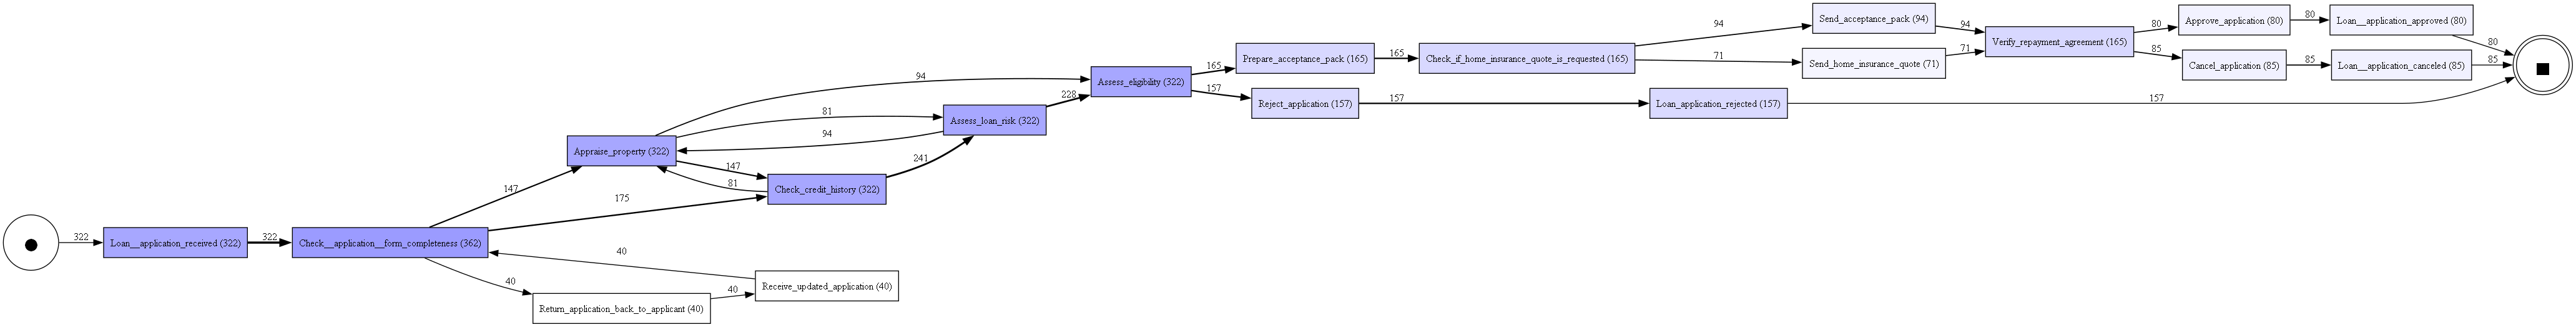

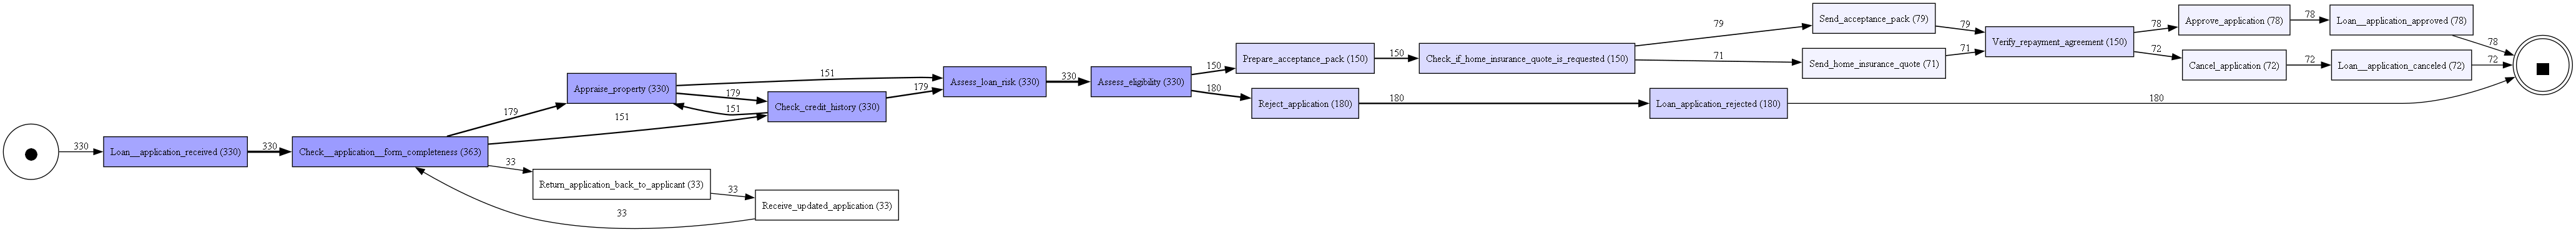

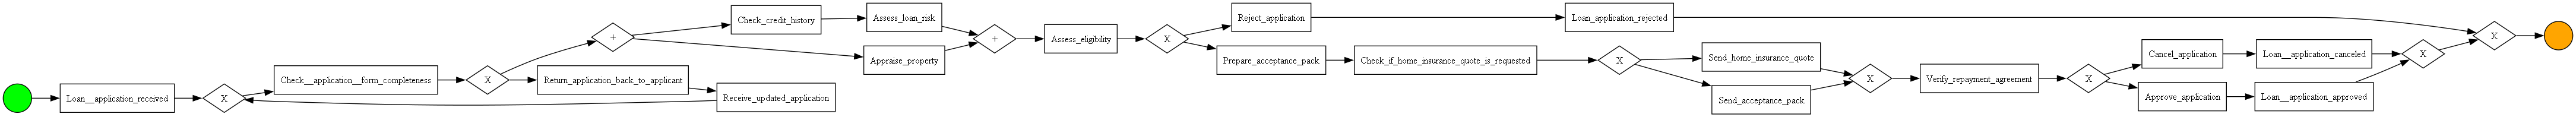

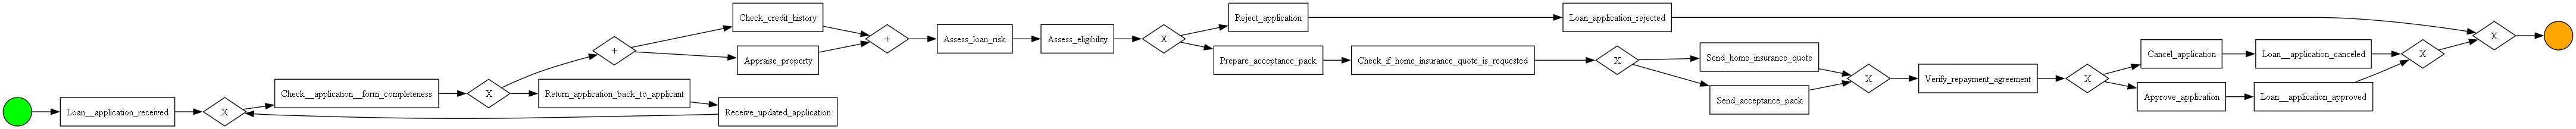

In [69]:
def create_dfg_from_dataset(dataset):
    # Creating a DFG from the dataset
    dfg_transitions = {(row['activity_from'], row['activity_to']): row['frequency'] for index, row in dataset.iterrows() if row['frequency'] > 0}

    # Identifying real start activities
    real_start_activities = set(to for from_, to in dfg_transitions if from_ == 'START')
    start_activities_freq = {activity: dfg_transitions[('START', activity)] for activity in real_start_activities}

    # Identifying real end activities
    real_end_activities = set(from_ for from_, to in dfg_transitions if to == 'END')
    end_activities_freq = {activity: dfg_transitions[(activity, 'END')] for activity in real_end_activities}

    # Removing transitions that involve 'START' and 'END'
    dfg_transitions = {k: v for k, v in dfg_transitions.items() if 'START' not in k and 'END' not in k}

    return create_dfg_from_transitions(dfg_transitions, start_activities_freq, end_activities_freq)

def create_dfg_from_transitions(dfg_transitions, start_activities_freq, end_activities_freq):
    dfg = DFG()

    # Adding transitions to the DFG
    for (from_act, to_act), count in dfg_transitions.items():
        dfg.graph[(from_act, to_act)] += count

    # Adding real start activities
    for act, count in start_activities_freq.items():
        dfg.start_activities[act] += count

    # Adding real end activities
    for act, count in end_activities_freq.items():
        dfg.end_activities[act] += count

    return dfg

# Call function to create the DFG
reference_dfg = create_dfg_from_dataset(reference_window_df)
detection_dfg = create_dfg_from_dataset(detection_window_df)

# Show results
display(reference_dfg)
display(detection_dfg)


pm4py.view_dfg(reference_dfg.graph, reference_dfg.start_activities, reference_dfg.end_activities)
pm4py.view_dfg(detection_dfg.graph, detection_dfg.start_activities, detection_dfg.end_activities)

reference_bpmn = pm4py.discover_bpmn_inductive(reference_dfg)
detection_bpmn = pm4py.discover_bpmn_inductive(detection_dfg)

pm4py.view_bpmn(reference_bpmn)
pm4py.view_bpmn(detection_bpmn)

In [70]:
def compare_dfgs(dfg1, dfg2):
    # Get transitions
    dfg1_transitions = set(dfg1.graph.keys())
    dfg2_transitions = set(dfg2.graph.keys())

    # Calculate new, deleted, and altered transitions
    new_transitions = dfg2_transitions - dfg1_transitions
    deleted_transitions = dfg1_transitions - dfg2_transitions
    
    # Get activities
    dfg1_activities = set(t[0] for t in dfg1.graph.keys()) | set(t[1] for t in dfg1.graph.keys())
    dfg2_activities = set(t[0] for t in dfg2.graph.keys()) | set(t[1] for t in dfg2.graph.keys())

    # Calculate new and deleted activities
    new_activities = dfg2_activities - dfg1_activities
    deleted_activities = dfg1_activities - dfg2_activities
    
    # Get start and end activities
    dfg1_start_activities = set(dfg1.start_activities.keys())
    dfg2_start_activities = set(dfg2.start_activities.keys())
    dfg1_end_activities = set(dfg1.end_activities.keys())
    dfg2_end_activities = set(dfg2.end_activities.keys())

    # Calculate new and deleted start and end activities
    new_start_activities = dfg2_start_activities - dfg1_start_activities
    deleted_start_activities = dfg1_start_activities - dfg2_start_activities
    new_end_activities = dfg2_end_activities - dfg1_end_activities
    deleted_end_activities = dfg1_end_activities - dfg2_end_activities

    dfg_changes = {
        'Transitions_new': list(new_transitions)
        ,'Transitions_Deleted': list(deleted_transitions)
        ,'Activities_new': list(new_activities)
        ,'Activities_Deleted': list(deleted_activities)
        # ,'Start_Activities_new': list(new_start_activities)
        # ,'Start_Activities_Deleted': list(deleted_start_activities)
        # ,'End_Activities_new': list(new_end_activities)
        # ,'End_Activities_Deleted': list(deleted_end_activities)

        # ,'Transitions_reference': list(dfg1_transitions)
        # ,'Transitions_detection': list(dfg2_transitions)
        # ,'Activities_reference': list(dfg1_activities)
        # ,'Activities_detection': list(dfg2_activities)
        # ,'Start_Activities_reference': list(dfg1_start_activities)
        # ,'Start_Activities_detection': list(dfg2_start_activities)
        # ,'End_Activities_reference': list(dfg1_end_activities)
        # ,'End_Activities_detection': list(dfg2_end_activities)
    }

    return dfg_changes

# Compare DFGs
dfg_changes_result = compare_dfgs(reference_dfg, detection_dfg)

# Show the changes
display(dfg_changes_result)

{'Transitions_new': [],
 'Transitions_Deleted': [('Appraise_property', 'Assess_eligibility'),
  ('Assess_loan_risk', 'Appraise_property')],
 'Activities_new': [],
 'Activities_Deleted': []}

In [71]:
# Covert DFG to process trees 
reference_process_tree = inductive_miner.apply(reference_dfg, parameters={"noise_threshold": 1.0}) 
detection_process_tree = inductive_miner.apply(detection_dfg, parameters={"noise_threshold": 1.0}) 

reference_bpmn_text = reference_process_tree._get_root()
detection_bpmn_text = detection_process_tree._get_root()

display(reference_bpmn_text)
display(detection_bpmn_text)


c:\Users\anton\OneDrive\_Cloud Disk\Projetos de programação\Git\Transition_Matrix_Process_Drift\.venv\Lib\site-packages\pm4py\algo\discovery\inductive\algorithm.py:78: UserWarning: Inductive Miner Variant requested for DFG artefact is not IMD, resorting back to IMD
  warnings.warn('Inductive Miner Variant requested for DFG artefact is not IMD, resorting back to IMD')


->( 'Loan__application_received', *( 'Check__application__form_completeness', ->( 'Return_application_back_to_applicant', 'Receive_updated_application' ) ), +( 'Appraise_property', ->( 'Check_credit_history', 'Assess_loan_risk' ) ), 'Assess_eligibility', X( ->( 'Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', X( 'Send_acceptance_pack', 'Send_home_insurance_quote' ), 'Verify_repayment_agreement', X( ->( 'Cancel_application', 'Loan__application_canceled' ), ->( 'Approve_application', 'Loan__application_approved' ) ) ), ->( 'Reject_application', 'Loan_application_rejected' ) ) )

->( 'Loan__application_received', *( 'Check__application__form_completeness', ->( 'Return_application_back_to_applicant', 'Receive_updated_application' ) ), +( 'Appraise_property', 'Check_credit_history' ), 'Assess_loan_risk', 'Assess_eligibility', X( ->( 'Prepare_acceptance_pack', 'Check_if_home_insurance_quote_is_requested', X( 'Send_acceptance_pack', 'Send_home_insurance_quote' ), 'Verify_repayment_agreement', X( ->( 'Cancel_application', 'Loan__application_canceled' ), ->( 'Approve_application', 'Loan__application_approved' ) ) ), ->( 'Reject_application', 'Loan_application_rejected' ) ) )

In [72]:
change_informations = changed_transitions_result_dict | dfg_changes_result
display(change_informations)

{'Changed_transition_probability': [('Appraise_property',
   'Assess_eligibility'),
  ('Appraise_property', 'Assess_loan_risk'),
  ('Assess_loan_risk', 'Appraise_property'),
  ('Assess_loan_risk', 'Assess_eligibility'),
  ('Check_credit_history', 'Appraise_property'),
  ('Check_credit_history', 'Assess_loan_risk')],
 'Changed_transition_frequency': [('Appraise_property', 'Assess_eligibility'),
  ('Appraise_property', 'Assess_loan_risk'),
  ('Assess_loan_risk', 'Appraise_property'),
  ('Assess_loan_risk', 'Assess_eligibility'),
  ('Check_credit_history', 'Appraise_property'),
  ('Check_credit_history', 'Assess_loan_risk')],
 'Transitions_new': [],
 'Transitions_Deleted': [('Appraise_property', 'Assess_eligibility'),
  ('Assess_loan_risk', 'Appraise_property')],
 'Activities_new': [],
 'Activities_Deleted': []}

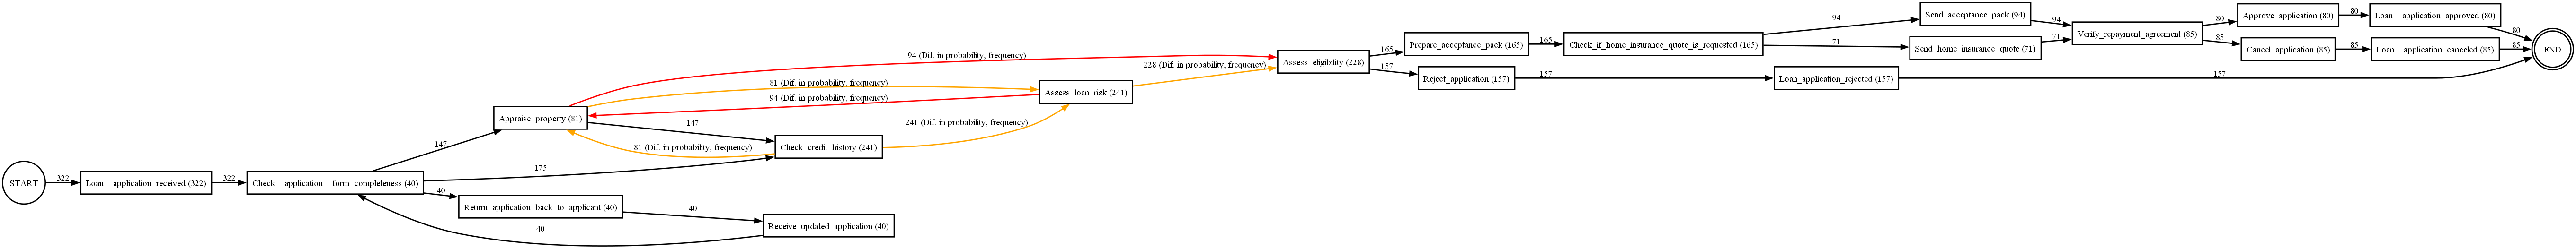

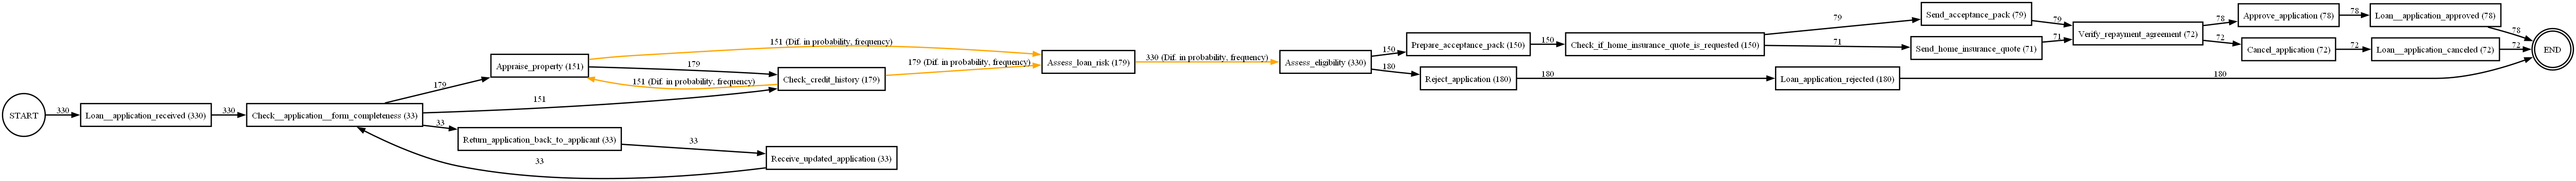

In [73]:
from graphviz import Digraph
from IPython.display import display, Image

def dfg_visualization(dfg, change_informations, bgcolor="white", rankdir="LR", node_penwidth="2", edge_penwidth="2"):
    
    dfg_graph = dfg.graph
    start_activities = dfg.start_activities
    end_activities = dfg.end_activities
    new_transitions = change_informations['Transitions_new']
    deleted_transitions = change_informations['Transitions_Deleted']
    new_activities = change_informations['Activities_new']
    deleted_activities = change_informations['Activities_Deleted']

    edge_annotations = {}
    for key, transitions in {key: val for key, val in change_informations.items() if key.startswith("Changed_transition_")}.items():
        suffix = key.split('_')[-1]  # Extract suffix
        for transition in transitions:
            if transition in edge_annotations:
                edge_annotations[transition].append(suffix)
            else:
                edge_annotations[transition] = [suffix]


    dot = Digraph(engine='dot', graph_attr={'bgcolor': bgcolor, 'rankdir': rankdir})

    # Create a unique start and end node for visualization
    dot.node('START', shape='circle', label='START', width='0.8', style='filled', fillcolor='white', penwidth=node_penwidth)
    dot.node('END', shape='doublecircle', label='END', width='0.8', style='filled', fillcolor='white', penwidth=node_penwidth)

    # Add nodes and edges to the graph
    for (source, target), count in dfg_graph.items():
        # Set node shapes and labels
        source_label = f"{source} ({start_activities.get(source, count)})"
        target_label = f"{target} ({end_activities.get(target, count)})"

        # Determine node colors based on activity status
        source_color = 'blue' if source in new_activities else 'red' if source in deleted_activities else 'black'
        target_color = 'blue' if target in new_activities else 'red' if target in deleted_activities else 'black'

        # # Add nodes
        dot.node(source, label=source_label, shape='box', style='filled', fillcolor='white', color=source_color, penwidth=node_penwidth)
        dot.node(target, label=target_label, shape='box', style='filled', fillcolor='white', color=target_color, penwidth=node_penwidth)

        # Set edge colors based on transition type
        edge_color = 'black'
        if (source, target) in new_transitions:
            edge_color = 'blue'
        elif (source, target) in deleted_transitions:
            edge_color = 'red'
        elif (source, target) in edge_annotations:
            edge_color = 'orange'

        # Add edges
        if (source, target) in edge_annotations:
            dot.edge(source, target, label=str(count) + ' (Dif. in ' +', '.join(edge_annotations[(source, target)]) + ')', color=edge_color, penwidth=edge_penwidth) 
        else: 
            dot.edge(source, target, label=str(count), color=edge_color, penwidth=edge_penwidth)

    # Connect the start node to the real start activities and the real end activities to the end node
    for act in start_activities:
        if act not in end_activities:  # Avoid connecting end activities again
            count = start_activities.get(act, 0)  # Get the count for the activity

            # Set edge colors based on transition type
            edge_color = 'black'
            if ('START', act) in new_transitions:
                edge_color = 'blue'
            elif ('START', act) in deleted_transitions:
                edge_color = 'red'
            elif ('START', act) in edge_annotations:
                edge_color = 'orange'

            if ('START', act) in edge_annotations: 
                dot.edge('START', act, label=str(count) + ' (Dif. in ' +', '.join(edge_annotations[('START', act)]) + ')', color=edge_color, style='bold', penwidth=edge_penwidth)
            else:
                dot.edge('START', act, label=str(count), color=edge_color, style='bold', penwidth=edge_penwidth)

    for act in end_activities:
        if act not in start_activities:  # Avoid connecting start activities again
            count = end_activities.get(act, 0)  # Get the count for the activity

            # Set edge colors based on transition type
            edge_color = 'black'
            if (act, 'END') in new_transitions:
                edge_color = 'blue'
            elif (act, 'END') in deleted_transitions:
                edge_color = 'red'
            elif (act, 'END') in edge_annotations:
                edge_color = 'orange'

            if (act, 'END') in edge_annotations: 
                dot.edge(act, 'END', label=str(count) + ' (Dif. in ' +', '.join(edge_annotations[(act, 'END')]) + ')', color=edge_color, style='bold', penwidth=edge_penwidth)
            else:
                dot.edge(act, 'END', label=str(count), color=edge_color, style='bold', penwidth=edge_penwidth)


    # Render and display the graph inline in Jupyter Notebook
    png_data = dot.pipe(format='png')
    display(Image(png_data))

# Usage example
dfg_visualization(reference_dfg, change_informations)
dfg_visualization(detection_dfg, change_informations)


### Common control-flow change patterns in business processes: 
- SRE: Insert/delete an activity between two activities.
    - Template: from ->A->B-> to ->A->C->B-> or vice versa.
    - Characterization statement: After the drift, activity C is inserted (resp., deleted from) between activities A and B.

- PRE: Insert/delete an activity in/from parallel branch.
    - Template: from ->A->B->C-> to ->A->[B,D]->C-> or vice versa.
    - Characterization statement: 
        - Insert: After the drift, activity D is inserted between activities A and C in a parallel branch (with activity B). 
        - Delete: After the drift, activity D which was in a parallel branch (with activity B) between activities A and C is deleted.

- CRE: Insert/delete an activity in/from conditional branch.
    - Template: from ->A->B?->C-> to ->A->{D|B?}->C-> or vice versa.
    - Characterization statement: 
        - Insert: After the drift, activity D is inserted between activities A and C in a conditional branch (with activity B). 
        - Delete: After the drift, activity D which was in a conditional branch (with activity B) between activities A and C is deleted.

- CP: Duplicate an activity.
    - Template: from ->A->B->C-> to ->A->B->C->A-> or vice versa.
    - Characterization statement: After the drift, activity A, is inserted and became duplicated in the process (continues with SRE, PRE, or CRE).

- RP: Substitute an activity.
    - Template: from ->A->B->C-> to ->A->D->C->.
    - Characterization statement: After the drift, activity B, which was between activities A and C, is substituted by activity D.

- SW: Swap two activities.
    - Template: from ->A->B->C->D->E->F-> to ->A->E->C->D->B->F->.
    - Characterization statement: After the drift, activity B, which was between activities A and C, is swapped with activity E, which was between activities D and F.

- SM: Move an activity to between two activities.
    - Template: from ->A->B->C->D->E-> to ->A->C->D->B->E->.
    - Characterization statement: After the drift, activity B, which was between activities A and C, has moved to between activities D and E.

- CM: Move an activity into/out of conditional branch.
    - Template: from ->A->B->C->D->E?->F-> to ->A->C->D->{B|E?}->F-> or vice versa.
    - Characterization statement: After the drift, activity B, which was between activities A and C, has moved to between activities D and F and in a conditional branch (with activity E).

- PM: Move an activity into/out of parallel branch.
    - Template: from ->A->B->C->D->E->F-> to ->A->C->D->[B,E]->F-> or vice versa.
    - Characterization statement: After the drift, activity B, which was between activities A and C, has moved to between activities D and F and in a parallel branch with activity E.

- CF: Make activity mutually exclusive/sequential.
    - Template: from ->A->{B|C}->D-> to ->A->B->C->D-> or vice versa.
    - Characterization statement: Before the drift, activities B and C were mutually exclusive (resp., sequential), while after the drift, they are sequential (resp., mutually exclusive).

- PL: Make activities parallel/sequential.
    - Template: from ->A->[B,C]->D-> to ->A->B->C->D-> or vice versa.
    - Characterization statement: Before the drift, activities B and C were parallel (resp., sequential), while after the drift, they are sequential (resp., parallel).

- CD: Synchronize two activities.
    - Template: from ->A->[B,{C|D}]->E-> to ->A->[B->C,{C|D}]->E-> or vice versa.
    - Characterization statement: Before the drift, activities B and C were parallel (resp., synchronized), while after the drift they are synchronized (resp., parallel).

- LP: Make activities loopable/non-loopable.
    - Template: from ->A->B->C->D->E-> to ->A->B->C->D->{loop to B}->E-> or vice versa.
    - Characterization statement: After the drift, activities B, C and D have become loopable/non-loopable.

- CB: Make an activity skippable/non-skippable.
    - Template: from ->A->B->C-> to ->A->B?->C-> or vice versa.
    - Characterization statement: After the drift, activity B has become skippable/non-skippable.

- FR: Change branching frequency.
    - Template: from ->A->{B(40%)|C(60%)}->V-> to ->A->{B(70%)|C(30%)}->V-> or vice versa.
    - Characterization statement: After the drift, following activity A, branch of activity B is more frequently executed, while branch of activity C is less frequently executed.


### Custom BPMN-Like Text Representation Guide:

- Sequential Activities:
    - Represented as: A->B->C
    - Example: One activity following another in sequence.

- AND Gateway (Parallel Processing):
    - Represented as: A->[B,C]->D
    - Example: Activity A leads to parallel activities B and C, which then converge before moving to D. The square brackets [ ] denote parallel activities.

- XOR Gateway (Exclusive Decision):
    - Represented as: A->{B|C}->D
    - Example: Activity A leads to a decision point where either B or C is chosen, but not both. The curly braces { } with a vertical bar | indicate an XOR decision.

- Optional or skippable Activity:
    - Represented as: A->B?->C
    - Example: Activity B, between A and C, is optional or can be skipped. The question mark ? after an activity denotes that it is optional/skippable, leading to either A->B->C or A->C.

- Loopable Flow:
    - Format: A->B->C->{loop to A}->D
    - Example: Normal flow is A->B->C->D, but there's a loop from C back to A.

- XOR Gateway with Percentages:
    - Format: A->{B(60%)|C(40%)}->D
    - Example: After A, there's a 60% chance of choosing B and a 40% chance of choosing C, before moving to D.

- Combining Gateways:
    - Represented as: A->{B->[D,E]|C}->F
    - Example: A combination of AND and XOR gateways, where A leads to an XOR decision between B (which further leads to parallel activities D and E) and C, before proceeding to F.

Note: This guide is a custom representation for BPMN-like processes in text format. The symbols used (->, [ ], { }, ?) are part of the notation developed for this specific purpose.

In [74]:
# Common_Change_Patterns_List = ['sre', 'pre', 'cre', 'cp', 'rp', 'sw', 'cm', 'pm', 'cf', 'pl', 'cd', 'lp', 'cb', 'fr']

# Maaradji = cb, cd, cf, cm, cp, fr, lp, pl, pm, re, rp, sw

# Ostovar = ConditionalMove, ConditionalRemoval, ConditionaToSequence, Frequency, Loop, ParallelMove, ParallelRemoval, ParallelToSequence, SerialMove, SerialRemoval, Skip, Substitute, Swap

### SRE (Serial Routing Enablement)
sre_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'SRE' (Serial Routing Enablement) involves the addition or deletion of one or more activities between two existing activities." 
    "For example, the sequence could change from '->(A, B)' to '->(A, C, B)' or vice versa, where 'A', 'B', and 'C' are activities, and '->' symbolizes sequential flow." 
    "This scenario implies that after the drift, activity 'A' is inserted in the process and in a sequential flow between other two activities, in this case 'A' and 'B', "
    "or it could be deleted from the process and from a sequential flow bteween two other activities."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information shows differences in Sequences (->) fragments, "
    "if the involved activities are new or deleted, and if they have new and deleted transitions. ")

### PRE (Parallel Routing Enablement)
pre_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'PRE' (Parallel Routing Enablement) involves the addition or deletion of one or more activities in or from a parallel branch." 
    "For example, the sequence could change from '->(A, B, C)' to '->(A, +(B, D), C)' or vice versa, where 'A', 'B', 'C', and 'D' are activities, '->' symbolizes sequential flow, " 
    "and '+' represents an AND or parallel operation within the BPMN (Business Process Model and Notation)."
    "This scenario implies that after the drift, activitiy 'D' is  inserted in the process and in a parallel branch, or 'D' could be deleted from the process and from a parallel branch."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information shows new or deleted ANDs (+) fragments, "
    "if the involved activities are new or deleted, and if they have new and deleted transitions. ")

### CRE (Conditional Routing Enablement)
cre_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'CRE' (Conditional Routing Enablement) involves the addition or deletion of one or more activities in or from a conditional branch."
    "For example, the sequence could change from '->(A, B, C)' to '->(A, X(B, D), C)' or vice versa, where 'A', 'B', 'C', and 'D' are activities, '->' symbolizes sequential flow, " 
    "and 'X' represents a XOR or conditional operation within the BPMN (Business Process Model and Notation)."
    "This scenario implies that the drift, activitiy 'D' is  inserted in the process and in a conditional branch, or 'D' could be deleted from the process and from a conditional branch."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information shows new or deleted XORs (X) fragments, "
    "if the involved activities are new or deleted, and if they have new and deleted transitions. ")

### CP (Copy) 
cp_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'CP' (Copy) involves duplicate an existing activity of the process to another location in the process." 
    "For example, the sequence could change from '->(A, B, C, D)' to '->(A, B, C, A, D)' or vice versa, where 'A', 'B', 'C', and 'D' are activities, '->' indicates a sequential operation."
    "This scenario implies that after the drift, activities 'A' appears in another location in the process as well."
    "Note: Identifying this pattern can be challenging, especially because neither the BPMN diagrams nor the transitions information may be correctly identified the duplication of an activity."
    "Both informations may only show that the duplicated activity has new transitions or maybe identify the duplication as a loop."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates the new transitions." 
    "Using the previous example, activity 'A' would have a new transition from activity 'C' ('C', 'A') and a new transition to activity 'D' ('A', 'D')." 
    "These two new transitions should be undestood as a new addition between 'C' and 'D', and, consequently, identified the duplication of 'A'.")

### RP (Replace)
rp_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'RP' (Replace) involves the replace of one or more activities by other new activities." 
    "For example, the sequence could change from '->(A, B, C)' to '->(A, D, C)', where 'A', 'B', 'C', and 'D' are activities, '->' symbolizes sequential flow."  
    "This scenario implies that after the drift, activity 'B' is replaced by activity 'D', which are a new activity in the process."
    "Tip: This scenario involve the addition and deletion, so look if activities are inserted and another deleted.")

### SW (Swap)
sw_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'SW' (Swap) involves the swap of two existing activities in the process." 
    "For example, the sequence could change from '->(A, B, C, D, E, F)' to '->(A, E, C, D, B, F)', where 'A', 'B', 'C', 'D', 'E', and 'F' are activities, '->' symbolizes sequential flow."  
    "This scenario implies that after the drift, activity 'B' is swapped with activity 'E'."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information may shows the activities in different locations in the process, both occupying the exact position of the other, "
    "and if both involved activities have new and deleted transitions. This scenario does not involve activities addition or deletion.")

### SM (Serial Move)
sm_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'SM' (Serial Move) involves move an existing activity to between two existing activities." 
    "For example, the sequence could change from '->(A, B, C, D, E)' to '->(A, C, D, B, E)', where 'A', 'B', 'C', 'D', and 'E' are activities, '->' symbolizes sequential flow."  
    "This scenario implies that after the drift, activity 'B', which was between activities 'A' and 'C', is moved to between activities 'D' and 'E'."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information may shows the activity in different locations in the process, "
    "and if the involved activitiy have new and deleted transitions. This scenario does not involve activities addition or deletion.")

### CM (Conditional Move)
cm_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'CM' (Conditional Move) involves move an existing activity into or out of a conditional branch." 
    "For example, the sequence could change from '->(A, B, C, D, E, F)' to '->(A, C, D, X(B, E), F)', where 'A', 'B', 'C', 'D', 'E', and 'F' are activities, '->' symbolizes sequential flow, "
    "and 'X' represents a XOR or conditional operation within the BPMN (Business Process Model and Notation)."  
    "This scenario implies that after the drift, activity 'B', which was between activities 'A' and 'C', is moved to between activities 'D' and 'F' and in a conditional branch with activity 'E'."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information may shows the activity in different locations in the process, shows new or deleted XORs (X) fragments, "
    "and if the involved activitiy have new and deleted transitions. This scenario does not involve activities addition or deletion.")

### PM (Parallel Move)
pm_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'PM' (Parallel Move) involves move an existing activity into or out of a parallel branch." 
    "For example, the sequence could change from '->(A, B, C, D, E, F)' to '->(A, C, D, +(B, E), F)', where 'A', 'B', 'C', 'D', 'E', and 'F' are activities, '->' symbolizes sequential flow, "
    "and '+' represents an AND or parallel operation within the BPMN (Business Process Model and Notation)." 
    "This scenario implies that after the drift, activity 'B', which was between activities 'A' and 'C', is moved to between activities 'D' and 'F' and in a parallel branch with activity 'E'."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information may shows the activity in different locations in the process, shows new or deleted ANDs (+) fragments, "
    "and if the involved activitiy have new and deleted transitions. This scenario does not involve activities addition or deletion.")

### CF (Conflict)
cf_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'CF' (Conflict) involves making activities initially mutually exclusive to be sequential, or vice versa." 
    "For example, the sequence could change from '->(A, X(B, C), D)' to '->(A, B, C, D)' or vice versa, where 'A', 'B', 'C', and 'D' are activities, '->' indicates a sequential operation, "
    "and 'X' represents a XOR or conditional operation within the BPMN (Business Process Model and Notation)."
    "This indicates that before the drift, activities 'B' and 'C' were mutually exclusive, suggesting that only one could occur in any process instance, "
    "while after the drift, they have become sequential, implying a fixed order of execution."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information shows new or deleted XORs (X) fragments, "
    "and if the involved activities have new and deleted transitions. This scenario does not involve activities addition or deletion.")

### PL (Parallel)
pl_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'PL' (Parallel) involves making activities initially parallel to be sequential, or vice versa." 
    "For example, the sequence could change from '->(A, +(B, C), D)' to '->(A, B, C, D)' or vice versa, where 'A', 'B', 'C', and 'D' are activities, '->' indicates a sequential operation, "
    "and '+' represents an AND or parallel operation within the BPMN (Business Process Model and Notation)."
    "This indicates that before the drift, activities 'B' and 'C' were parallel, suggesting that both would occur with no defined order between them,"
    "while after the drift, they have become sequential, implying a fixed order of execution."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information shows new or deleted ANDs (+) fragments, "
    "and if the involved activitiy have new and deleted transitions. This scenario does not involve activities addition or deletion.")

### CD (Control Dependancy) or Synchronization
cd_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'CD' (Control Dependancy) involves synchronizing two or more activities, where the convergence of multiple branches into a single subsequent branch occurs "
    "such that the thread of control passes to the subsequent branch only when all preceding branches have been executed." 
    "For example, the sequence could change from '->(A, +(B, ->(C, D)), E)' to '->(A, ->(+(B, C), D), E)' or vice versa, where 'A', 'B', 'C', and 'D' are activities, '->' indicates a sequential operation, "
    "and '+' represents an AND or parallel operation within the BPMN (Business Process Model and Notation)."
    "This scenario implies that before the drift, activities 'B', 'C', and 'D' could proceed in parallel, but after the drift, 'B' and 'C' need to synchronize before initiating 'D'."
    "Tip: In such scenarios, it's advisable to delve deeper and investigates if the BPMN information shows differences inside ANDs (+) fragments, "
    "and if the involved activitiy have new and deleted transitions. This scenario does not involve activities addition or deletion.")

### LP (Loop)
lp_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'LP' (Loop) involves making activities initially loopable to be non-loopable, or vice versa." 
    "For example, the sequence could change from '->(A, *(B, C, D), E)' to '->(A, B, C, D, E)' or vice versa, where 'A', 'B', 'C', 'D', and 'E' are activities, '->' indicates a sequential operation, "
    "and '*' represents a loop operation within the BPMN (Business Process Model and Notation)."
    "This indicates that before the drift, activities 'B', 'C', and 'D' were in a loop, while after the drift, they were not in a loop."
    "Tip: In such scenarios, if the BPMN information doesn't show the loop, it's advisable to delve deeper and investigates if deleted transitions led to activities that could lead to the activity in question, " 
    "which define a loop in the process.")

### CB (Conditional Branching) or Skip
cb_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'CB' (Conditional Branching) involves the modifications to the skippability of one or more activities. Specifically, an activity might become optional (skippable) or mandatory (non-skippable)." 
    "For example, the sequence could change from '->(A, B, C)' to '->(A, X(B, null), C)', where 'A', 'B', and 'C' are activities, '->' indicates a sequential operation, "
    "and 'X' represents a XOR or conditional operation within the BPMN (Business Process Model and Notation)."
    "The term 'null' is used to indicate the absence of an activity in that branch, highlighting the conditional execution of 'B'."
    "Note: Identifying this pattern can be challenging, especially in BPMN diagrams where the new conditional operations or XOR may not be correctly identified because of the branch with no activitiy, "
    "making the new skippable nature of 'B' less apparent."
    "Tip: In such scenarios, investigates all new or deleted transition carefully to understanding if it could represent a change in the skippablability to others activities. "
    "Using our previous example, the new transition between 'A' to 'C' is causing B to become skippable. This scenario does not involve activities addition or deletion.")

### FR (Frequency)
fr_instructions = (
    # "\n### Change Pattern Instruction ###\n"
    "The 'FR' (Frequency) involves change the branching frequency of activities." 
    "For example, the sequence could change from '->(A, X(B[550], C[450]), D)' to '->(A, X(B[700], C[300]), D)' or vice versa, where 'A', 'B', 'C', and 'D' are activities, '->' symbolizes sequential flow, " 
    "'X' represents a XOR or conditional operation within the BPMN (Business Process Model and Notation), and the information inside the '[]' represent the activity frequency."
    "This indicates that before the drift, activity 'B' and 'C' frequency were similar, while after the drift, they were different."
    "In other words, before the drift, the frequency of activities 'B' and 'C' had not statistical difference, and after the drift, theirs frequencies had statiscial difference."
    "Note: In such scenarios, the involved activities hasn't any control-flow difference before and after the drift, only the branch frequency or branch probability have difference."
    "Tip: Investigate activities which are in XORs (X) fragments, and transitions which are in Changed_transition_probability or Changed_transition_frequency but is not in Transitions_new or Transitions_deleted.")


In [75]:
# general_introduction = ("\n### Introduction ###\n" 
#                         "You are an assistant specialized in process mining analysis." 
#                         "Your task involves investigating a phenomenon known as 'concept drift' in a business process." 
#                         "Concept drift refers to changes in the process behavior over time.")


# concept_drift_informations = ("\n### Changes Informations ###\n"
#                               "You have identified significant differences between two specific time periods (or 'windows') in the business process."
#                               "These differences are indicative of concept drift, and here's a breakdown to help analyze these changes:"
#                                 "- 'Changed_transition_probability': Transitions with altered occurrence likelihood, suggesting shifts in procedural focus or priorities."
#                                 "- 'Changed_transition_frequency': Transitions whose frequency of occurrence has changed, indicating variations in process activity importance or volume."
#                                 "- 'Transitions_new': New transitions introduced, signifying additions to the business process steps or procedures."
#                                 "- 'Transitions_Deleted': Removed transitions, which could indicate process simplification or the phasing out of certain tasks."
#                                 "- 'Activities_new': New activities that reflect evolving business needs or enhancements in process efficiency."
#                                 "- 'Activities_Deleted': Eliminated activities, pointing to streamlining efforts or a shift in task valuation."
#                                 # "- 'Start_Activities_new': Activities that have become new starting points, possibly due to changes in initial conditions or process initiation."
#                                 # "- 'Start_Activities_Deleted': Former starting activities no longer used, suggesting a redefinition of entry criteria or process scope."
#                                 # "- 'End_Activities_new': New endpoints for the process, indicating changes in goals, outcomes, or deliverables."
#                                 # "- 'End_Activities_Deleted': Activities no longer serving as process endpoints, signaling a shift in desired process outcomes."
#                                 # "- 'Transitions_reference': Baseline transitions from the initial observation window, providing a reference for original process flow."
#                                 # "- 'Transitions_detection': Observed transitions in the later window, aiding in identifying concept drift occurrences."
#                                 # "- 'Activities_reference': Baseline list of activities from the initial window, establishing process component reference points."
#                                 # "- 'Activities_detection': Activities identified in the later window, for comparison with the reference to detect changes."
#                                 # "- 'Start_Activities_reference': Initial window starting activities, outlining how the process originally began."
#                                 # "- 'Start_Activities_detection': Later window starting activities, useful for detecting initiation shifts."
#                                 # "- 'End_Activities_reference': Original endpoint activities, clarifying initial goals or completion criteria."
#                                 # "- 'End_Activities_detection': Later observed endpoint activities, helping recognize changes to process goals or outcomes."
#                                 # "This structured information provides a comprehensive view of the concept drift within the business process, facilitating a detailed analysis."
#                                 # "Each category should be examined for its impact on the process's efficiency, effectiveness, and adaptability to changing business requirements."
#                                 "Follow the informations: {0}.").format(change_informations)

# bpmn_windows_informations = ("\n### BPMN Informations ###\n"
#                              "For both periods under review, you have BPMN (Business Process Model and Notation) diagrams that outline the process flows." 
#                              "In these diagrams, '->' denotes a sequential operation, '+' indicates parallel operations, 'X' represents XOR/conditional operations, and parentheses enclose fragments involved in these operations."
#                              "There may be nested operations within these fragments."
#                              "The BPMN for the reference period is: {0}. The BPMN for the period where the drift was detected is: {1}.").format(reference_bpmn_text, detection_bpmn_text)

# question = ("\n### Question ###\n"
#             "Analyse the changes informations provided, analyse differences between both BPMN provided, and determine if the described change pattern has occurred." 
#             "Think step by step."
#             # "Please process the information step by step and conclude with a clear determination of the presence or absence of the change pattern." 
#             "Accuracy is crucial, and incorrect answers will be penalized."
#             "Only confirm if you have enough evidence."
#             "Note: End with a python dict format, following this example: '### result_dict = {'Answer' : 'Yes', 'Activities' : [A, B]}' or '### result_dict = {'Answer' : 'No', 'Activities' : []}'.")

In [76]:
general_introduction = ("\n### Objective ###\n" 
                        "Your primary task is to explore the concept drift within a business process, which refers to the evolution or changes in the process's behavior over time. " 
                        "You will use BPMN (Business Process Model and Notation) diagrams and changes informations from two distinct periods to identify these changes. ")

bpmn_windows_informations = ("\n### BPMN Diagram Analysis ###\n"
                             "Understand BPMN Symbols: Familiarize yourself with the BPMN symbols used in the diagrams. " 
                             "Sequential operations are denoted by '->', parallel operations by '+', conditional operations by 'X', looping operations by '*', and silent transitions by 'tau'. Nested operations are enclosed in parentheses '()'. "
                             "Compare BPMN Diagrams: You are given two BPMN diagrams representing the process flow before and after the detection of concept drift. " 
                             "Carefully compare these diagrams to identify any structural changes in the sequences, including the addition or deletion of activities. "
                             "The BPMN for the reference period is: {0}. The BPMN for the period where the drift was detected is: {1}. ").format(reference_bpmn_text, detection_bpmn_text)


concept_drift_informations = ("\n### Changes Information Analysis ###\n"
                              "You will also be provided with a detailed breakdown of the changes between the two periods, categorized as follows: "
                                "- Changed_transition_probability: Transitions with altered occurrence likelihood. "
                                "- Changed_transition_frequency: Transitions whose frequency of occurrence has changed. "
                                "- Transitions_new: New transitions introduced into the process. "
                                "- Transitions_Deleted: Removed transitions. "
                                "- Activities_new: New activities added to the process. "
                                "- Activities_Deleted: Activities removed from the process. "
                                "Analyze these changes to understand the nature and impact of the concept drift. "
                                "Follow the changes informations: {0}.").format(change_informations)

question = ("\n### Conclusion Formation ###\n"
            "Based on your analysis of the BPMN diagrams and the detailed changes information, conclude whether a concept drift occurred, which specific change pattern has occurred (the most likely), and which activities are involved. "
            "Your conclusion must be supported by evidence from your analysis, and be aware that another change pattern may has occurred and not the one you are analyzing. "
            "Format your conclusion as follows, providing a clear and concise verdict on whether the change pattern is present: "
            "'### result_dict = {'Concept drift' : 'No', 'Change pattern' : 'None', 'Activities' : []} " 
            "or '### result_dict = {'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['A', 'B']} "
            "or '### result_dict = {'Concept drift' : 'Yes', 'Change pattern' : 'pattern_acronym', 'Activities' : ['A', 'B']}. "
            )

# question = ("\n### Conclusion Formation ###\n"
#             "Based on your analysis of the BPMN diagrams and the detailed changes information, conclude whether a concept drift occurred, whether this specific change pattern has occurred, and which activities are involved. "
#             "Your conclusion must be supported by evidence from your analysis, and be aware that another change pattern may has occurred and not the one you are analyzing. "
#             "Format your conclusion as follows, providing a clear and concise verdict on whether the change pattern is present: "
#             "'### result_dict = {'Concept drift' : 'No', 'Change pattern' : 'None', 'Activities' : []} " 
#             "or '### result_dict = {'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['A', 'B']} "
#             "or '### result_dict = {'Concept drift' : 'Yes', 'Change pattern' : 'pattern_acronym', 'Activities' : ['A', 'B']}. "
#             # "Your analysis and conclusion are crucial in understanding the impact of concept drift on the business process. Approach this task methodically, focusing on accuracy and evidence to support your conclusions. "
#             )


In [77]:
import os
from openai import OpenAI
from langchain_openai import ChatOpenAI

# insert API_TOKEN in the file to be read here
with open('Temp/open_ai_token.txt', 'r') as file:
    os.environ["OPENAI_API_KEY"] = file.read().rstrip()


# Instanciating OpenAI 
client = OpenAI()

def openai_response_call(system_content, user_content):
  completion = client.chat.completions.create(
    temperature=0
    , top_p=0.000000000000001
    , seed=42
    , model="gpt-4-1106-preview"
    # , model="gpt-3.5-turbo-0125"
    # , model = "gpt-4"
    , messages=[
      {"role": "system", "content": system_content},
      {"role": "user", "content": user_content}
    ]
  )
  return completion

# Instanciating LLM using LangChain
llm = ChatOpenAI(model_name="gpt-4-1106-preview", temperature=0) # GPT-4 Turbo , model_kwargs={"top_p": 0.1}
# llm = ChatOpenAI(model_name="gpt-3.5-turbo-0125", temperature=0) # GPT-3.5 Turbo , model_kwargs={"top_p": 0.1}

# Create a function to ask questions
def llm_response_call(question, model):
    response = model.invoke(question)
    return response

In [78]:
# Prompt example
# print(general_introduction + bpmn_windows_informations + concept_drift_informations + sre_instructions + question)

In [79]:
### Common change patterns testing
Common_Change_Patterns_List = ['sre', 'pre', 'cre', 'cp', 'rp', 'sw', 'cm', 'pm', 'cf', 'pl', 'cd', 'lp', 'cb', 'fr']
# Common_Change_Patterns_List = ['sre', 'cb', 'cd', 'cf'] #
change_patterns_prompt = "\n### Change Pattern Instruction ###"

for change_pattern in Common_Change_Patterns_List:

    change_patterns_prompt = change_patterns_prompt + " \n " + eval(f'{change_pattern}_instructions')


# print(change_patterns_prompt)

# Using openAI lib
system_content = general_introduction
user_prompt = change_patterns_prompt + bpmn_windows_informations + concept_drift_informations + question

response = openai_response_call(system_content, user_prompt)
print("\n### LLM's response: \n", response.choices[0].message.content)

# Finding the start and end of the dictionary string
start_str = "result_dict = {"
end_str = "}"
start_index = response.choices[0].message.content.find(start_str) + len(start_str) - 1
end_index = response.choices[0].message.content.find(end_str, start_index) + 1

classification_response = response.choices[0].message.content[start_index:end_index].strip()


display("\n### Final resposnses: \n", classification_response)


### LLM's response: 
 ### BPMN Diagram Analysis ###

By comparing the BPMN diagrams before and after the drift, we can identify the following differences:

1. In the reference period BPMN, there is a parallel branch that includes 'Check_credit_history' and 'Assess_loan_risk' as sequential activities: 
   `+( 'Appraise_property', ->( 'Check_credit_history', 'Assess_loan_risk' ) )`
   
2. In the period where the drift was detected, the parallel branch has been removed, and 'Assess_loan_risk' follows 'Appraise_property' directly in a sequential manner, while 'Check_credit_history' precedes 'Appraise_property':
   `+( 'Appraise_property', 'Check_credit_history' ), 'Assess_loan_risk'`

### Changes Information Analysis ###

The detailed changes information provides the following insights:

- `Changed_transition_probability` and `Changed_transition_frequency` include the same set of transitions, indicating that the frequency and likelihood of these transitions have changed but do not provide

'\n### Final resposnses: \n'

"{'Concept drift' : 'Yes', 'Change pattern' : 'PL', 'Activities' : ['Check_credit_history', 'Assess_loan_risk']}"

In [28]:
# ### Common change patterns testing
# Common_Change_Patterns_List = ['sre', 'pre', 'cre', 'cp', 'rp', 'sw', 'cm', 'pm', 'cf', 'pl', 'cd', 'lp', 'cb', 'fr']
# # Common_Change_Patterns_List = ['sre', 'cb', 'cd', 'cf'] #
# Common_Change_Patterns_LLM_Response = {}

# for change_pattern in Common_Change_Patterns_List:
#     print("\n########################## Change Pattern: {0} ########################## \n".format(change_pattern))
#     # # Using LangChain lib
#     # change_pattern_prompt = general_introduction + bpmn_windows_informations + concept_drift_informations + eval(f'{change_pattern}_instructions') + question
#     # change_pattern_response = llm_response_call(change_pattern_prompt, llm)
#     # display("LLM's response to {0} question:".format(change_pattern), change_pattern_response)

#     # Using openAI lib
#     system_content = general_introduction
#     change_pattern_prompt = eval(f'{change_pattern}_instructions') + bpmn_windows_informations + concept_drift_informations + question
#     # change_pattern_prompt = bpmn_windows_informations + concept_drift_informations + eval(f'{change_pattern}_instructions') + question
#     # print("\n### LLM's input: \n", system_content, change_pattern_prompt)
    
#     change_pattern_response = openai_response_call(system_content, change_pattern_prompt)
#     print("\n### LLM's response: \n", change_pattern_response.choices[0].message.content)

#     # Finding the start and end of the dictionary string
#     start_str = "result_dict = {"
#     end_str = "}"
#     start_index = change_pattern_response.choices[0].message.content.find(start_str) + len(start_str) - 1
#     end_index = change_pattern_response.choices[0].message.content.find(end_str, start_index) + 1

#     Common_Change_Patterns_LLM_Response[change_pattern] = change_pattern_response.choices[0].message.content[start_index:end_index].strip()

#     # Common_Change_Patterns_LLM_Response[change_pattern] = change_pattern_response.choices[0].message.content.split('result_dict =')[-1].strip()

# display("\n### Final resposnses: \n", Common_Change_Patterns_LLM_Response)


########################## Change Pattern: sre ########################## 


### LLM's response: 
 ### BPMN Diagram Analysis ###

Let's compare the BPMN diagrams from the reference period and the period where the drift was detected:

**Reference Period BPMN:**
->( X( ->( 'a', +( 'c', 'e', 'd' ) ), ->( 'b', +( 'f', 'g', 'h' ) ) ), 'i', *( X( 'j', 'k' ), tau ), +( 's', ->( +( 'l', 'm' ), 'r' ) ), 't', 'DRIFT_PO', *( X( 'n', 'o' ), tau ), 'p', *( X( 'x', 'v', 'u', 'w' ), tau ), 'y', 'z' ).

**Drift Detected Period BPMN:**
->( X( ->( 'a', +( 'c', 'e', 'd' ) ), ->( 'b', +( 'f', 'g', 'h' ) ) ), 'i', *( X( 'j', 'k' ), tau ), +( 's', ->( +( 'l', 'm' ), 'r' ) ), 't', 'DRIFT_PO', 'n', 'o', 'p', *( X( 'x', 'v', 'u', 'w' ), tau ), 'y', 'z' ).

Comparing the two, we can see that the looping structure `*( X( 'n', 'o' ), tau )` after 'DRIFT_PO' in the reference period is no longer present in the period where the drift was detected. Instead, we have a direct sequence of 'n', 'o', 'p'. This indicates 

'\n### Final resposnses: \n'

{'sre': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['n', 'o']}",
 'pre': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['n', 'o']}",
 'cre': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['n', 'o']}",
 'cp': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : []}",
 'rp': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['n', 'o']}",
 'sw': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : []}",
 'cm': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['n', 'o']}",
 'pm': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['n', 'o']}",
 'cf': "{'Concept drift' : 'Yes', 'Change pattern' : 'CF', 'Activities' : ['n', 'o']}",
 'pl': "{'Concept drift' : 'Yes', 'Change pattern' : 'PL', 'Activities' : ['n', 'o']}",
 'cd': "{'Concept drift' : 'Yes', 'Change pattern' : 'Other', 'Activities' : ['n', 'o']}",
 'lp': "{'Concept 

In [18]:

### SRE testing

# # Using LangChain lib
# sre_prompt = general_introduction + bpmn_windows_informations + concept_drift_informations + sre_instructions + question
# sre_response = llm_response_call(sre_prompt, llm)
# display("LLM's response to SRE question:", sre_response)

# # Using openAI lib
# system_content = general_introduction
# sre_prompt = bpmn_windows_informations + concept_drift_informations + sre_instructions + question
# sre_response = openai_response_call(system_content, sre_prompt)
# display("LLM's response to SRE question:", sre_response)
